# Portfolio optimisation

In [1]:
from risk_management import value_at_risk as var
from risk_management import yftickers
from risk_management import funcs
from risk_management import portfolioTheory as pt
import timeit
import datetime as dt
import matplotlib.pyplot as plt
from dateutil import relativedelta as timerd
import pandas as pd
from scipy import stats
import numpy as np

# Portfolio

In [2]:
tickers = yftickers.simple
start=dt.datetime(2004,1,1)
end=dt.datetime(2023,1,1)
threshold=0.9

In [3]:
port1 = var.Portfolio(tickers=tickers, start=start, end=end, threshold=threshold)

[*********************100%***********************]  3 of 3 completed
No NAs in data
[*********************100%***********************]  1 of 1 completed
The data spans 4957 working days, but has 4625 observations.


In [4]:
port1.equally_weighted()

In [5]:
port1_returns = port1.portfolio_return[194:].drop(index=['2022-06-15','2022-06-14'])

<AxesSubplot:xlabel='Date'>

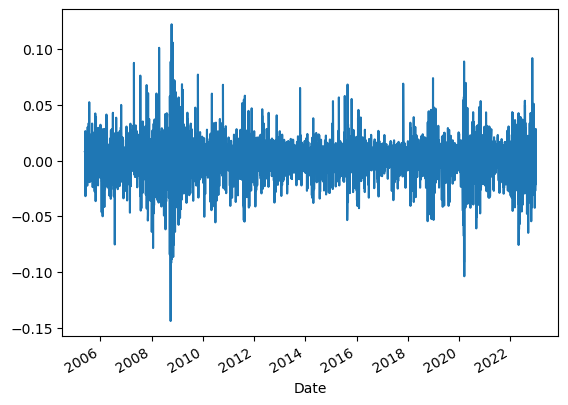

In [6]:
port1_returns.plot()

# Portfolio optimisation

In [8]:
weights = port1.weights
meanReturns = port1.log_returns.mean()
covMatrix = port1.log_returns.cov()

pt.portfolioPerformance(weights, meanReturns, covMatrix, T=252)

(0.235607126947256, 0.27835277362912164)

In [9]:
max_sharpe, max_sharpe_weights = pt.maxShapreRatio(meanReturns, covMatrix)
max_sharpe, max_sharpe_weights

     fun: -0.939836290231908
     jac: array([ 0.00005591, -0.00030463, -0.00011549])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.74770127, 0.06702797, 0.18527076])


(0.939836290231908,
 [array(['AAPL', 'AMZN', 'GOOG'], dtype=object),
  array([0.74770127, 0.06702797, 0.18527076])])

In [10]:
minVol, minVol_weights = pt.minimizeVariance(meanReturns, covMatrix)
minVol, minVol_weights

(0.2725163436688628,
 [array(['AAPL', 'AMZN', 'GOOG'], dtype=object),
  array([0.34464576, 0.16688541, 0.48846883])])

# Historical value at risk

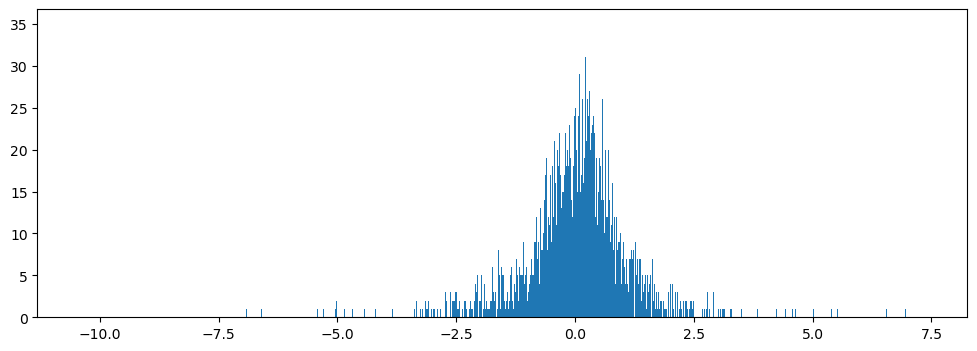

In [11]:
plt.figure(figsize=(12,4))
plt.margins(x=0)
plt.hist(round(port1_returns*100,3),bins=2000)

plt.show()

In [12]:
dfs = np.array_split(port1_returns, 17)

In [53]:
dfs[1].index[100].year

2007

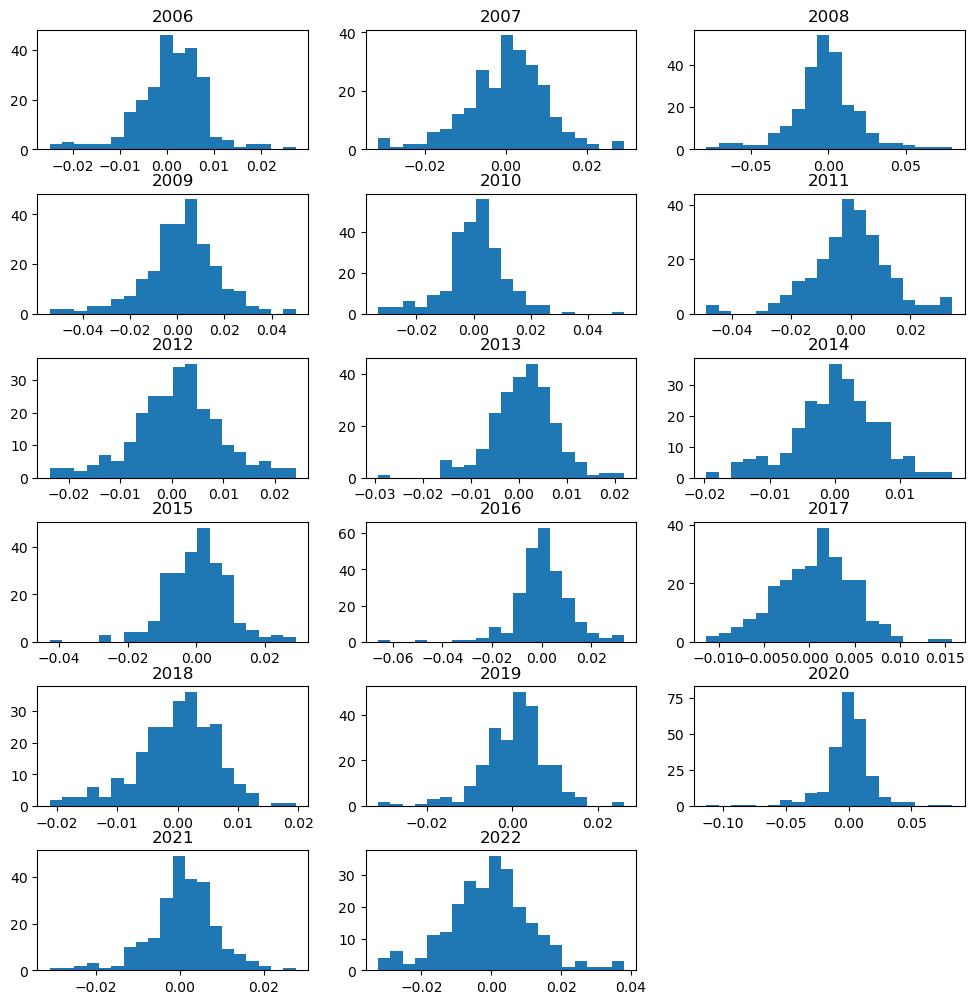

In [70]:
min1, max1 = port1_returns.min(),port1_returns.max()
fig, ax = plt.subplots(6,3,figsize=(10,10))
fig.delaxes(ax.flatten()[-1]) 
fig.tight_layout()
for i,x in enumerate(dfs):
    ax.flatten()[i].hist(x,bins=20)
#    ax.flatten()[i].set_xlim(min1,max1)
    ax.flatten()[i].set_title(dfs[i].index[100].year)
plt.show()

In [15]:
#Average days in the year
len(port1_returns)/len(port_returns.groupby(port1_returns.index.year))
#timerd.relativedelta(port1_returns.index[0],port1_returns.index[-1])

245.7058823529412

In [71]:
value_at_risk_95 = var.compute_var(port1_returns,5,246)
expected_shortfall_95 = var.compute_es(port1_returns,5,246)

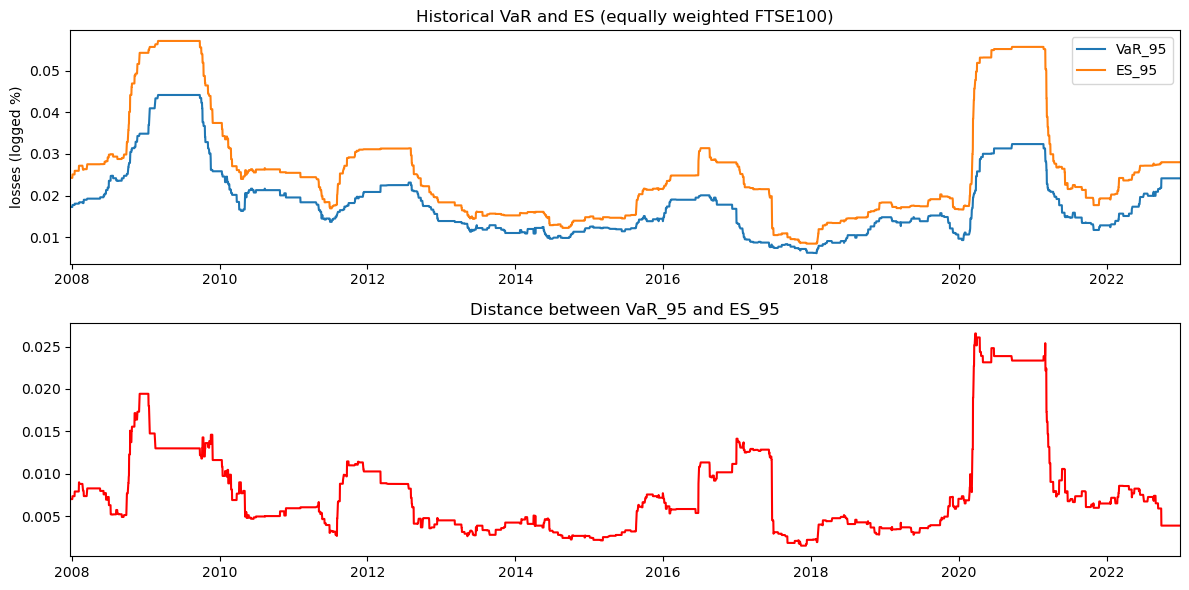

In [72]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,6))

ax1.plot(-value_at_risk_95[245:],label='VaR_95')
ax1.plot(-expected_shortfall_95[245:], label='ES_95')
ax1.set_title('Historical VaR and ES (equally weighted FTSE100)')
ax1.set_ylabel('losses (logged %)')
ax1.margins(x=0)
ax1.legend()

ax2.plot(value_at_risk_95[245:]-expected_shortfall_95[245:],color='r')
ax2.set_title('Distance between VaR_95 and ES_95')
ax2.margins(x=0)
fig.tight_layout()
plt.show()

In [73]:
var_breaches_95 = var.breaches(port1_returns,value_at_risk_95)
es_breaches_95 = var.breaches(port1_returns,expected_shortfall_95)

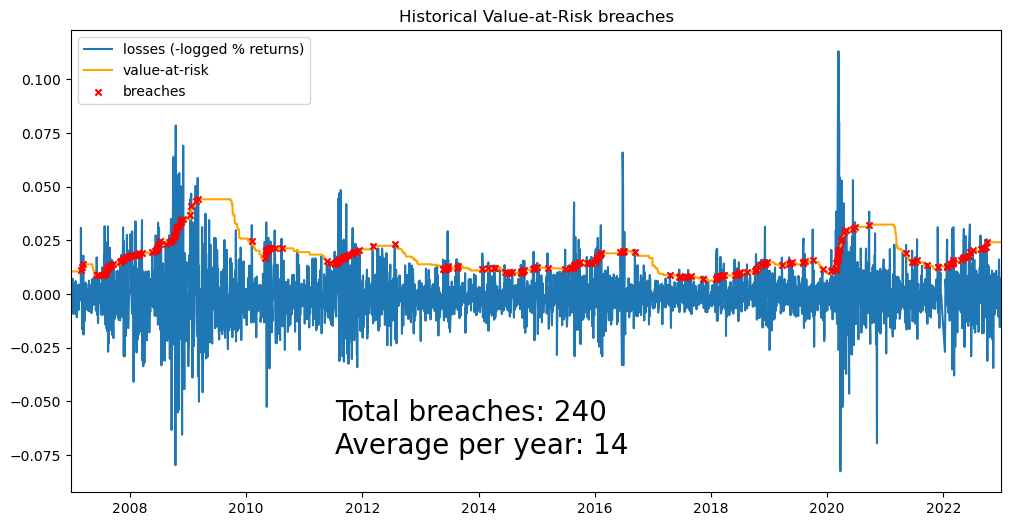

In [74]:
plt.figure(figsize=(12,6))
plt.plot(-port_returns[247:],label='losses (-logged % returns)')
plt.plot(-value_at_risk_95, color='orange',label='value-at-risk')
plt.scatter(var_breaches_95.index,-var_breaches_95,color='r',marker='x',zorder=2, s=20, label='breaches')
plt.margins(x=0)
plt.title('Historical Value-at-Risk breaches')
plt.text(value_at_risk_95.index[int(len(value_at_risk_95)/3.5)],min(-port_returns)*0.9,\
         'Total breaches: {}\nAverage per year: {}'.format(len(var_breaches_95),int(len(var_breaches_95)/17)),\
         fontsize=20)
plt.legend()
plt.show()

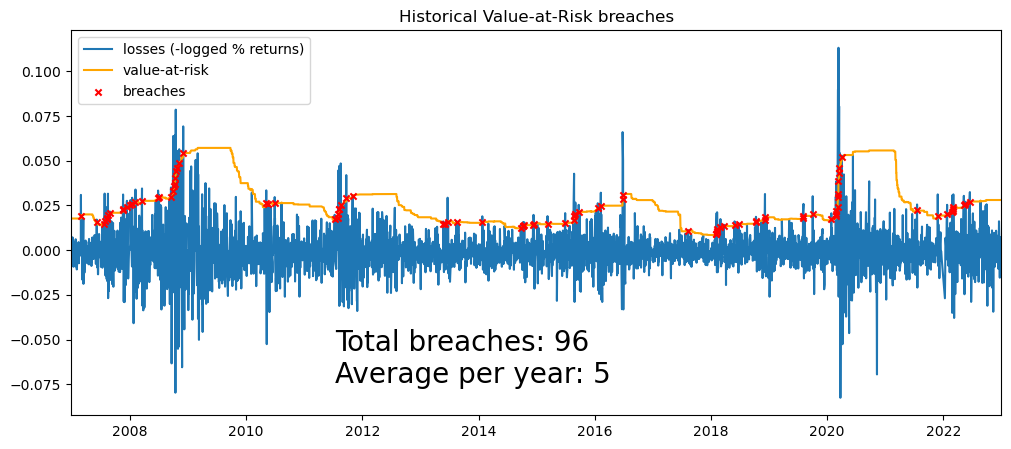

In [75]:
plt.figure(figsize=(12,5))
plt.plot(-port_returns[247:],label='losses (-logged % returns)')
plt.plot(-expected_shortfall_95, color='orange',label='value-at-risk')
plt.scatter(es_breaches_95.index,-es_breaches_95,color='r',marker='x',zorder=2, s=20, label='breaches')
plt.margins(x=0)
plt.title('Historical Value-at-Risk breaches')
plt.text(value_at_risk_95.index[int(len(value_at_risk_95)/3.5)],min(-port_returns)*0.9,\
         'Total breaches: {}\nAverage per year: {}'.format(len(es_breaches_95),int(len(es_breaches_95)/17)),\
         fontsize=20)
plt.legend()
plt.show()

ES seems to be more responsive to sudden changes in volatility and visually, the change is much steeper than the stepped adaptation of VaR. That is because VaR is merely a single figure as opposed to the expected shortfall which is more dynamically computed from the average of the losses exceeding the VaR.

In [76]:
es_breaches_95.groupby(by=es_breaches_95.index.year).count().mean()

6.857142857142857

In [81]:
np.random.normal(size=10000)

array([-2.13805613, -0.07068263,  1.04582756, ..., -0.00936997,
       -1.38554062, -1.28804021])

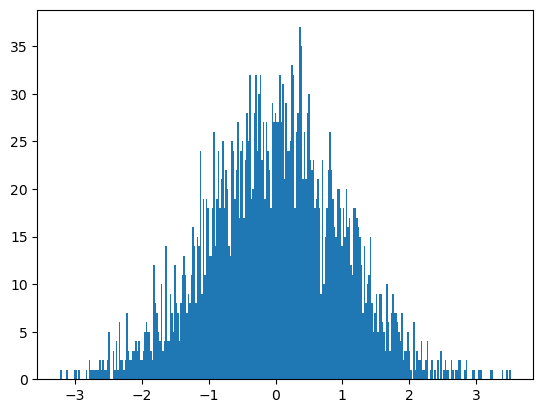

In [99]:
plt.hist(np.random.normal(size=3000),bins=300)
plt.show()

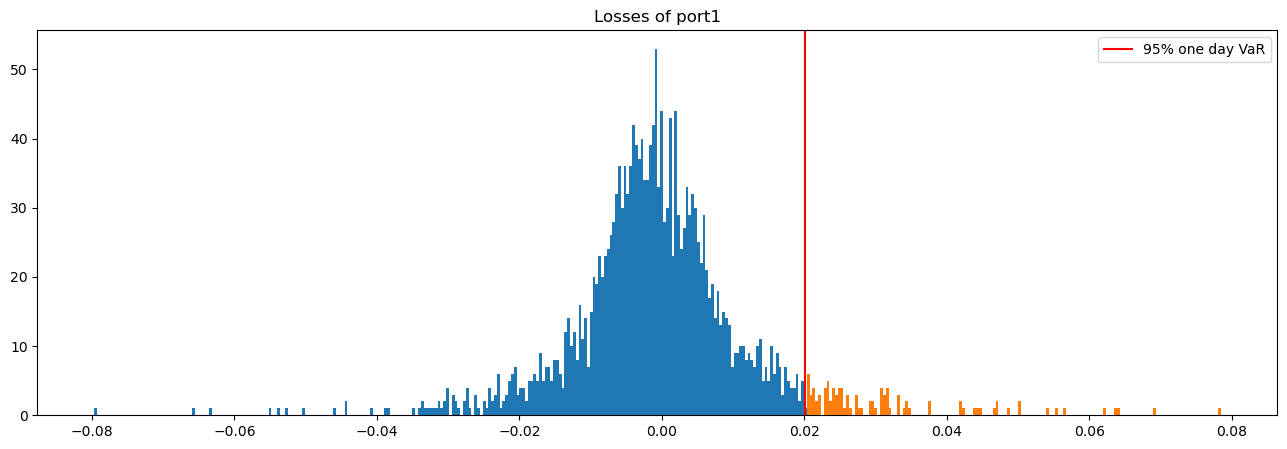

In [129]:
plt.figure(figsize=(16,5))
_, _, bars = plt.hist(-port1_returns[:2000],bins=400)
for bar in bars:
    if bar.get_x()>-var.compute_var(port1_returns[:2000],5):
        bar.set_facecolor("C1")
#plt.axvspan(-var.compute_var(port1_returns[:2000],5), -port1_returns.min(), color='lightgoldenrodyellow', zorder=0)
plt.axvline(x=-var.compute_var(port1_returns[:2000],5),color='r',label='95% one day VaR')
plt.title('Losses of port1')
plt.legend()
plt.show()

In [79]:
x.portfolio_prices[:500]

Date
2005-03-29    219.634804
2005-03-30    219.555565
2005-03-31    219.266343
2005-04-01    220.139989
2005-04-04    219.577919
                 ...    
2007-03-22    344.688679
2007-03-23    345.545046
2007-03-26    344.075849
2007-03-27    344.531012
2007-03-28    342.577171
Length: 500, dtype: float64

In [87]:
train = x.portfolio_prices[:500]

Initial set to 342.5771709374892


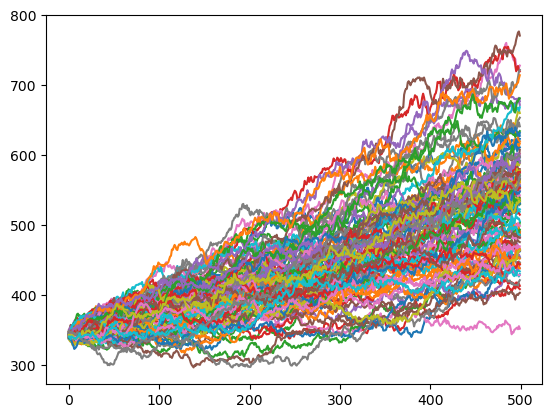

In [88]:
sims = funcs.MC_sim(train)

In [26]:
sims

NameError: name 'sims' is not defined

In [90]:
sims_df = pd.DataFrame(sims.T)
sims_var = []
for i in sims_df:
    sims_var.append(var.compute_var(sims_df[i],5,250))
#sims_var

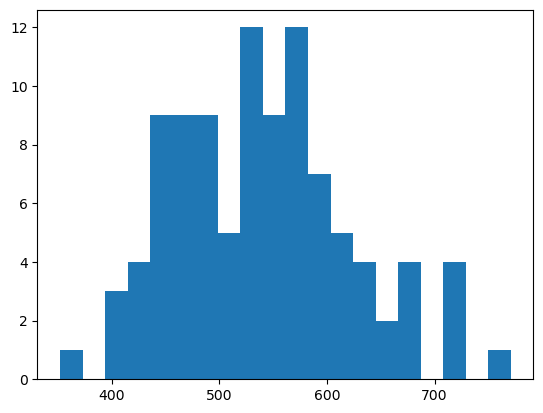

In [108]:
plt.hist(sims_df.iloc[-1],bins=20)
plt.show()

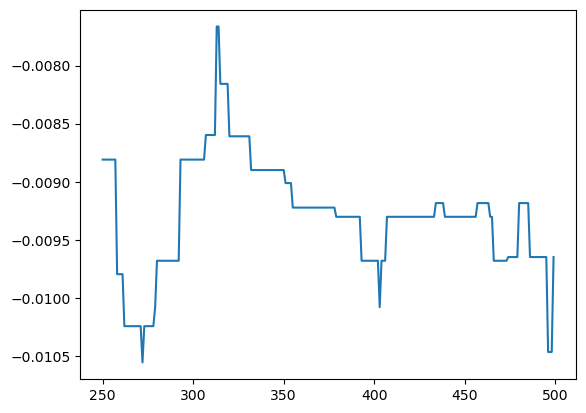

In [126]:
plt.plot(var.compute_var(var.compute_log_returns(sims_df[0]).dropna(),5,250))

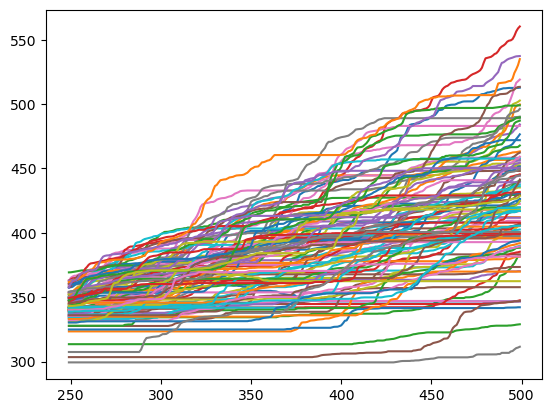

In [92]:
plt.plot(pd.DataFrame(sims_var).T)
plt.show()

In [ ]:
value_at_risk_95[]

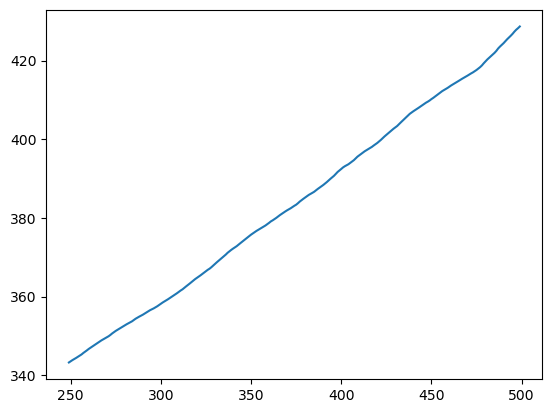

In [93]:
plt.plot(pd.DataFrame(sims_var).T.mean(axis=1))

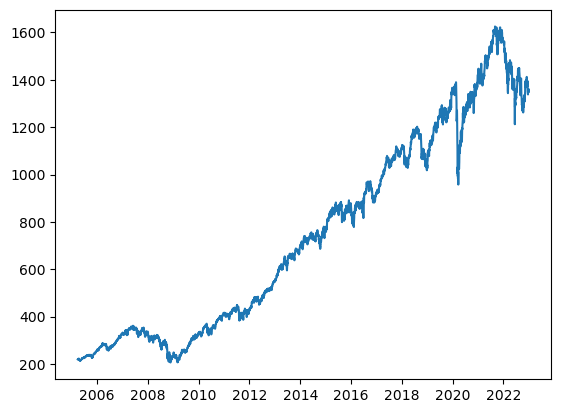

In [94]:
plt.plot(x.portfolio_prices)

C:\Users\44756\AppData\Local\Temp\ipykernel_26388\3823706913.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plt.plot(train.append(pd.DataFrame(sims_var).T.mean(axis=1)))


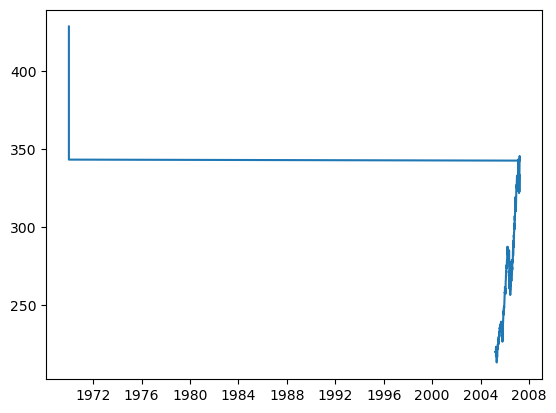

In [96]:
plt.plot(train.append(pd.DataFrame(sims_var).T.mean(axis=1)))

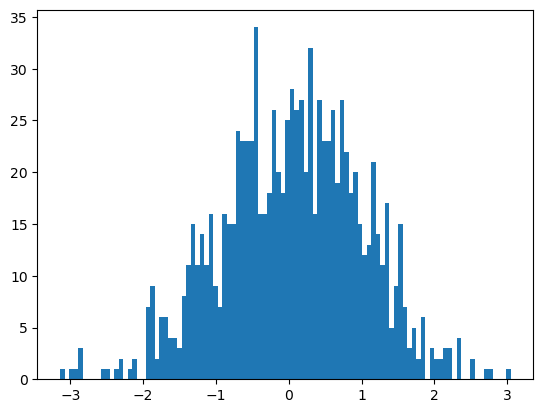

In [25]:
r = stats.norm.ppf(np.random.rand(1,1000))
plt.hist(r[0],bins=100)
plt.show()

In [86]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Define the expected returns and covariance matrix of the assets
returns = np.array([0.1, 0.2, 0.15])  # expected returns of the assets
cov_matrix = np.array([[0.05, 0.02, 0.01],
                       [0.02, 0.07, 0.03],
                       [0.01, 0.03, 0.06]])  # covariance matrix of the assets

# Define the number of portfolios to simulate
n_portfolios = 100

# Define a range of target expected returns to simulate
target_returns = np.linspace(0.05, 0.25, n_portfolios)

# Initialize arrays to store the portfolio weights and portfolio risk levels
portfolio_weights = np.zeros((n_portfolios, len(returns)))
portfolio_risks = np.zeros(n_portfolios)

# Set up the optimization problem
w = cp.Variable(len(returns))  # portfolio weights
ret = returns.T @ w  # portfolio expected return
risk = cp.quad_form(w, cov_matrix)  # portfolio risk

# Define the optimization problem
objective = cp.Minimize(risk)
constraints = [cp.sum(w) == 1, w >= 0]
problems = [cp.Problem(objective, [ret >= target_returns[i]] + constraints) for i in range(n_portfolios)]

# Solve the optimization problem for each target expected return
for i in range(n_portfolios):
    problems[i].solve()  # solve the optimization problem
    portfolio_weights[i] = w.value  # store the portfolio weights
    portfolio_risks[i] = np.sqrt(risk.value)  # store the portfolio risk level

# Plot the efficient frontier
plt.plot(portfolio_risks, target_returns, 'r-', label='Efficient Frontier')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.legend()
plt.show()


TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable sqrt method

In [87]:
import numpy as np
import cvxopt as opt
import matplotlib.pyplot as plt

# Define the expected returns and covariance matrix of the assets
returns = np.array([0.1, 0.2, 0.15])  # expected returns of the assets
cov_matrix = np.array([[0.05, 0.02, 0.01],
                       [0.02, 0.07, 0.03],
                       [0.01, 0.03, 0.06]])  # covariance matrix of the assets

# Define the number of portfolios to simulate
n_portfolios = 100

# Define a range of target expected returns to simulate
target_returns = np.linspace(0.05, 0.25, n_portfolios)

# Define the optimization problem
n_assets = len(returns)
P = opt.matrix(cov_matrix)
q = opt.matrix(np.zeros(n_assets))
G = opt.matrix(np.concatenate((-np.identity(n_assets), np.identity(n_assets))))
h = opt.matrix(np.concatenate((np.zeros(n_assets), np.ones(n_assets))))

# Solve the optimization problem for each target expected return
portfolio_weights = []
for target_return in target_returns:
    A = np.vstack((returns, np.ones(n_assets)))
    b = np.array([target_return, 1])
    x = np.linalg.solve(A, b)
    portfolio_weights.append(x)

portfolio_weights = np.array(portfolio_weights)

# Calculate the expected return and risk of each portfolio
portfolio_returns = np.dot(portfolio_weights, returns)
portfolio_risks = [np.sqrt(np.dot(np.dot(portfolio_weights[i], cov_matrix), portfolio_weights[i].T)) for i in range(n_portfolios)]

# Plot the efficient frontier
plt.plot(portfolio_risks, portfolio_returns, 'r-', label='Efficient Frontier')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.legend()
plt.show()

LinAlgError: Last 2 dimensions of the array must be square

In [96]:
x.log_returns.cov()

,ABF.L,ADM,AHT,ANTO.L,AON,AV.L,AVV.L,AZN,BA.L,BARC.L,...,STJ.L,SVT,TSCO,TW.L,ULVR.L,UTG,UU.L,VOD,WPP,WTB.L
ABF.L,0.000255,0.000062,0.000214,0.000161,0.000051,0.000141,0.000092,0.000055,0.000124,0.000211,...,0.000134,0.000024,0.000042,0.000173,0.000083,0.000070,0.000070,0.000087,0.000123,0.000142
ADM,0.000062,0.000397,0.000240,0.000188,0.000105,0.000144,0.000080,0.000104,0.000064,0.000166,...,0.000104,0.000052,0.000112,0.000107,0.000050,0.000130,0.000059,0.000148,0.000187,0.000108
AHT,0.000214,0.000240,0.002494,0.000343,0.000166,0.000288,0.000197,0.000154,0.000215,0.000443,...,0.000225,0.000089,0.000199,0.000310,0.000084,0.000245,0.000064,0.000260,0.000363,0.000290
ANTO.L,0.000161,0.000188,0.000343,0.010501,0.000112,0.000335,0.000222,0.000141,0.009837,0.010073,...,0.000289,0.000152,0.000122,0.000272,0.000095,0.000197,0.000133,0.000174,0.000292,0.000242
AON,0.000051,0.000105,0.000166,0.000112,0.000240,0.000098,0.000059,0.000079,0.000068,0.000121,...,0.000073,0.000027,0.000109,0.000104,0.000036,0.000091,0.000039,0.000096,0.000128,0.000072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UTG,0.000070,0.000130,0.000245,0.000197,0.000091,0.000131,0.000084,0.000094,0.000134,0.000218,...,0.000093,0.000047,0.000089,0.000102,0.000060,0.000245,0.000071,0.000122,0.000144,0.000098
UU.L,0.000070,0.000059,0.000064,0.000133,0.000039,0.000094,0.000067,0.000068,0.000116,0.000141,...,0.000084,0.000032,0.000037,0.000081,0.000075,0.000071,0.000189,0.000073,0.000077,0.000068
VOD,0.000087,0.000148,0.000260,0.000174,0.000096,0.000158,0.000084,0.000127,0.000113,0.000218,...,0.000123,0.000043,0.000109,0.000132,0.000060,0.000122,0.000073,0.000333,0.000204,0.000115
WPP,0.000123,0.000187,0.000363,0.000292,0.000128,0.000230,0.000153,0.000139,0.000178,0.000337,...,0.000188,0.000063,0.000145,0.000247,0.000066,0.000144,0.000077,0.000204,0.000434,0.000197


In [109]:
x.log_returns.mean()

ABF.L     0.000242
ADM       0.000399
AHT      -0.000926
ANTO.L    0.000557
AON       0.000640
            ...   
UTG       0.000380
UU.L      0.000318
VOD      -0.000029
WPP       0.000105
WTB.L     0.000294
Length: 78, dtype: float64

In [111]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Define the expected returns and covariance matrix of the assets
returns = port_returns  # expected returns of the assets
cov_matrix = np.array([[0.05, 0.02, 0.01],
                       [0.02, 0.07, 0.03],
                       [0.01, 0.03, 0.06]])  # covariance matrix of the assets

# Define the number of portfolios to simulate
n_portfolios = 100

# Define a range of target expected returns to simulate
target_returns = np.linspace(0.05, 0.25, n_portfolios)

# Initialize arrays to store the portfolio weights and portfolio risk levels
portfolio_weights = np.zeros((n_portfolios, len(returns)))
portfolio_risks = np.zeros(n_portfolios)

# Set up the optimization problem
w = cp.Variable(len(returns))  # portfolio weights
ret = returns.T @ w  # portfolio expected return
risk = cp.quad_form(w, cov_matrix)  # portfolio risk

# Define the optimization problem
objective = cp.Minimize(risk)
constraints = [cp.sum(w) == 1, w >= 0]

# Solve the optimization problem for each target expected return
for i in range(n_portfolios):
    problem = cp.Problem(objective, constraints + [ret >= target_returns[i]])
    problem.solve()  # solve the optimization problem
    portfolio_weights[i] = w.value  # store the portfolio weights
    if risk.value is not None:
        portfolio_risks[i] = np.sqrt(risk.value)  # store the portfolio risk level
    else:
        portfolio_risks[i] = 1e6  # set a large value to indicate infeasibility

# Plot the efficient frontier
plt.plot(portfolio_risks, target_returns, 'r-', label='Efficient Frontier')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.legend()
plt.show()


IndexError: tuple index out of range

,ABF.L,ADM,AHT,ANTO.L,AON,AV.L,AVV.L,AZN,BA.L,BARC.L,...,STJ.L,SVT,TSCO,TW.L,ULVR.L,UTG,UU.L,VOD,WPP,WTB.L
Date,,,,,,,,,,,,,,,,,,,,,
2005-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-30,-0.002638,-0.002870,0.029242,0.010429,0.010028,-0.002352,-0.014760,0.013296,-0.001912,-0.010959,...,-0.016294,0.009029,0.021304,-0.001624,0.015297,0.018829,0.000796,0.015463,0.011831,-0.001078
2005-03-31,-0.005298,0.009401,-0.020380,0.018190,-0.009152,-0.003145,0.000000,0.004056,-0.006721,-0.006449,...,0.006141,0.000000,-0.010710,-0.005703,-0.007619,0.015425,0.004765,-0.006006,-0.004222,0.004303
2005-04-01,0.000000,0.015742,-0.014815,-0.004713,-0.013666,0.000000,0.000000,-0.001773,0.024740,0.017408,...,-0.045937,0.033152,-0.030471,0.011373,0.000956,0.003057,0.004744,-0.008318,0.000529,0.010678
2005-04-04,-0.008000,-0.014116,0.003972,-0.021489,0.003102,-0.011882,0.000000,-0.004317,-0.007547,-0.005464,...,-0.004283,0.000000,0.014072,0.001614,-0.010562,0.002032,0.003935,0.004168,0.000705,0.002652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,-0.004770,-0.008308,-0.060756,-0.014858,-0.009549,-0.007372,-0.000934,0.002647,0.001394,-0.005964,...,-0.019586,0.000000,-0.005617,-0.004389,-0.002844,-0.004888,-0.012674,-0.007905,-0.007686,-0.010206
2022-12-23,0.011726,0.012014,0.017739,0.004869,0.001465,-0.004494,0.003110,-0.001470,-0.007690,0.003811,...,0.003673,0.064833,0.018647,0.008275,0.000237,0.010446,-0.003440,0.003960,0.007686,-0.003044
2022-12-28,0.000945,-0.010625,-0.089612,0.027154,-0.003599,0.008075,-0.001554,-0.006198,0.013938,0.007201,...,0.005029,-0.018742,0.012999,0.010608,-0.002019,-0.011847,0.009681,-0.005946,-0.020149,-0.000762


In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [125]:
mu

0    inf
dtype: float64

In [124]:
np.random.normal(mu, sigma, (forecast_horizon, num_simulations))

array([[nan, nan, nan, ..., nan, nan, nan]])

In [126]:
returns

,0
Date,
2005-03-30,inf
2005-03-31,1.013493
2005-04-01,0.915587
2005-04-06,-0.845554
2005-04-07,0.810395
...,...
2022-11-23,-0.187023
2022-11-25,-0.009578
2022-12-01,-0.478457


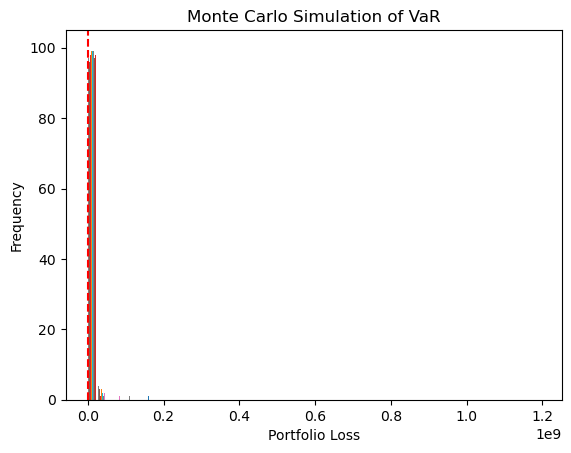

In [144]:
df = x.portfolio_return
returns = pd.DataFrame(np.log(df).diff().dropna())[1:]

mu = np.mean(returns)
sigma = np.std(returns)

num_simulations = 1000
forecast_horizon = 100
var_level = 0.01

simulated_returns = np.random.normal(mu, sigma, (forecast_horizon, num_simulations))

portfolio_value = 1000000
portfolio_loss = portfolio_value * (np.exp(simulated_returns) - 1)

var = np.percentile(portfolio_loss, var_level * 100)




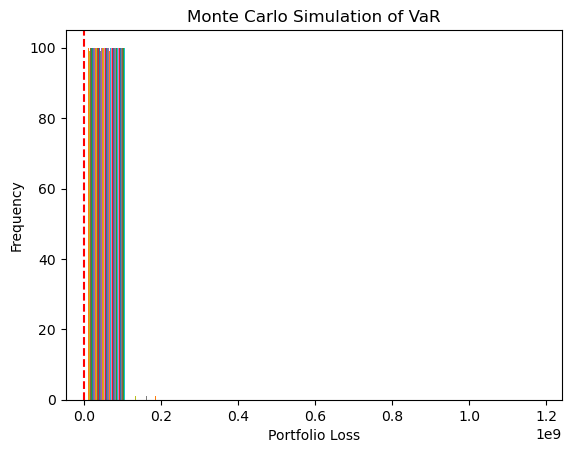

In [151]:
plt.hist(portfolio_loss)
plt.axvline(x=var, color='r', linestyle='--')
plt.title('Monte Carlo Simulation of VaR')
plt.xlabel('Portfolio Loss')
plt.ylabel('Frequency')
plt.show()

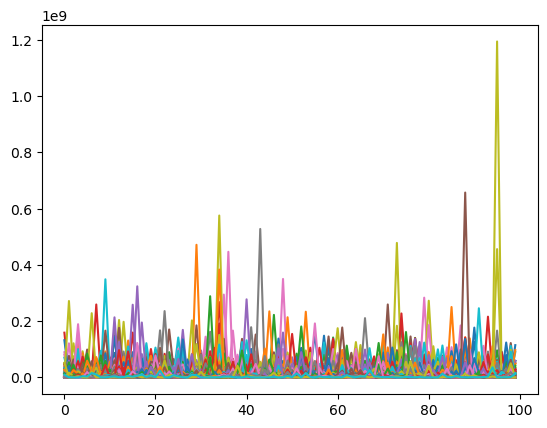

In [149]:
plt.plot(portfolio_loss)
plt.show()

In [146]:
simulated_returns.shape

(100, 1000)

In [138]:
portfolio_loss.shape

(10000,)

In [14]:
port_returns[port_returns>0.2]

Date
2022-06-15    0.314075
dtype: float64

In [18]:
x.raw_data.loc['2022-06-15']['Adj Close']

ABF.L     1585.356934
ADM         81.106453
AHT          6.010000
ANTO.L    1390.886963
AON        251.711884
             ...     
UTG         29.859262
UU.L       999.594727
VOD         14.826371
WPP         49.233440
WTB.L     2700.751953
Name: 2022-06-15 00:00:00, Length: 78, dtype: float64

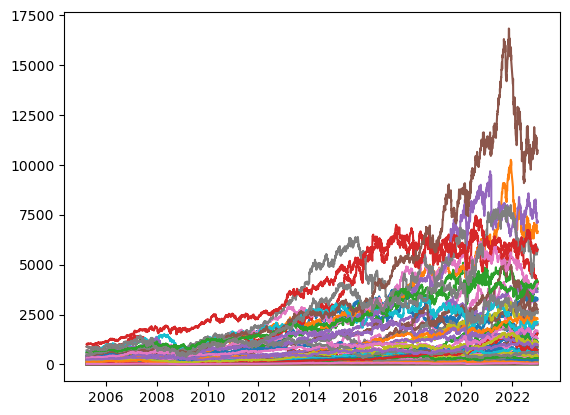

In [20]:
plt.plot(x.raw_data['Adj Close'])
plt.show()

In [30]:
x.log_returns.loc['2022-06-15']


ABF.L     0.029215
ADM      -0.004729
AHT       0.040753
ANTO.L    4.610897
AON       0.007932
            ...   
UTG       0.022394
UU.L      0.015923
VOD       0.018277
WPP       0.028199
WTB.L     0.060854
Name: 2022-06-15 00:00:00, Length: 78, dtype: float64

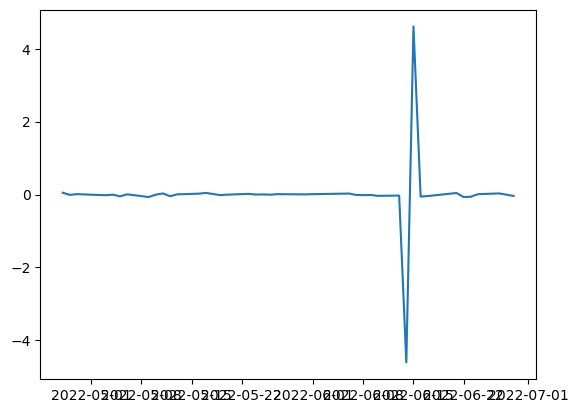

In [40]:
plt.plot(x.log_returns['ANTO.L'][4210:4250])

In [45]:
x.log_returns['ANTO.L'][x.log_returns['ANTO.L']>4]

Date
2022-06-15    4.610897
Name: ANTO.L, dtype: float64

In [38]:
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [46]:
x.log_returns.mean()

AAL      -0.000949
ABDN.L   -0.000417
ABF.L    -0.000289
ADM       0.000736
AHT      -0.003782
            ...   
UTG       0.000238
UU.L      0.000391
VOD      -0.000603
WPP      -0.000178
WTB.L    -0.000059
Length: 98, dtype: float64

In [45]:
# Read in price data
df = x.raw_data['Adj Close']
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

mu

AAL      -0.212787
ABDN.L   -0.099839
ABF.L    -0.070296
ADM       0.203823
AHT      -0.614413
            ...   
UTG       0.061750
UU.L      0.103506
VOD      -0.141003
WPP      -0.043919
WTB.L    -0.014752
Length: 98, dtype: float64

In [7]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

In [36]:
A

<1x1217 matrix, tc='d'>

In [34]:
n = len(x.log_returns)
returns = np.asmatrix(x.log_returns)

N = 100
mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

S = opt.matrix(np.cov(returns))
pbar = opt.matrix(np.mean(returns, axis=1))

G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
h = opt.matrix(0.0, (n ,1))
A = opt.matrix(1.0, (1, n))
b = opt.matrix(1.0)

portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]

ValueError: domain error

In [25]:
x.log_returns

,AAL,ABDN.L,ABF.L,ADM,AHT,ANTO.L,AON,AV.L,AVV.L,AZN,...,STJ.L,SVT,TSCO,TW.L,ULVR.L,UTG,UU.L,VOD,WPP,WTB.L
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.012342,-0.006840,0.020656,-0.007763,-0.034255,-0.026112,0.015844,0.000398,0.011637,0.001977,...,0.000000,-0.004598,0.007503,0.004794,0.003332,-0.005863,-0.014058,-0.006543,-0.031674,0.001007
2018-01-04,0.006285,0.012700,0.001761,0.016703,-0.013730,0.011217,0.013606,0.011072,0.003609,0.001409,...,0.005643,-0.009259,0.017808,-0.003833,0.003075,0.000653,-0.006729,0.009954,0.015628,0.006771
2018-01-05,-0.000380,-0.000467,0.013976,-0.006697,0.009174,-0.004472,0.008456,-0.003940,0.008608,0.010368,...,0.005611,0.018434,0.023177,0.013826,0.005267,0.004885,0.022256,0.008322,0.016705,-0.001751
2018-01-08,-0.009926,0.010235,-0.010464,-0.002243,0.007582,0.012350,0.000073,-0.000790,-0.005731,-0.006994,...,-0.005611,-0.031542,-0.002395,-0.012387,-0.000245,0.012591,-0.007118,0.002759,-0.005721,-0.009560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-12,0.102526,0.022631,0.026436,0.013363,0.150094,0.004549,0.027409,-0.014724,0.000311,-0.021458,...,0.077766,0.012238,-0.004520,0.058491,-0.003102,0.014350,0.019803,0.049056,0.042008,0.061453
2023-01-13,0.011226,0.015787,-0.003615,0.011491,0.015558,-0.006832,0.004107,-0.016743,0.000000,0.014169,...,-0.000402,-0.079536,0.001584,0.018470,0.007262,0.003308,-0.008163,-0.004442,0.013855,0.004295
2023-01-17,0.003519,0.016505,0.032071,-0.003513,0.000000,-0.005155,-0.000725,-0.005418,0.000311,-0.004795,...,0.006818,0.060237,-0.009544,0.019418,-0.011932,0.001980,0.002408,0.016777,0.001410,-0.001650


In [22]:
x.equally_weighted()

In [16]:
weights, returns, risks = optimal_portfolio(x.log_returns)

ValueError: domain error

In [142]:
port1.equally_weighted()

In [143]:
returns1 = port1.portfolio_return

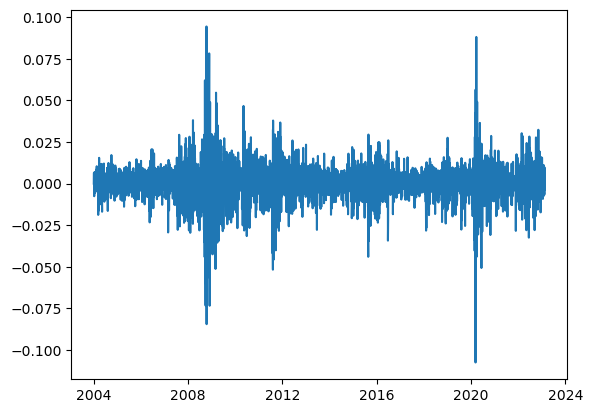

In [144]:
plt.plot(returns1)

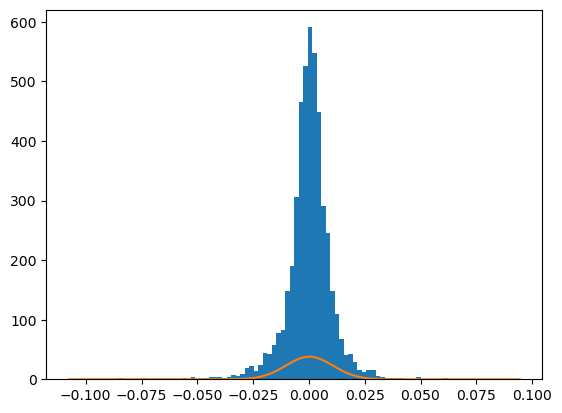

In [145]:
plt.hist(returns1,bins=100)
plt.plot(np.linspace(returns1.values.min(), returns1.values.max(),num=len(returns1)),norm.pdf(np.linspace(returns1.values.min(), returns1.values.max(),num=len(returns1)), returns1.mean(), returns1.std()))
plt.show()

In [146]:
skew = stats.skew(returns1, bias=False)
kurtosis = stats.kurtosis(returns1, bias=False)
print('Skew: {}, Kurtosis: {}'.format(skew,kurtosis))

Skew: -0.5892266197705675, Kurtosis: 12.183097818464548


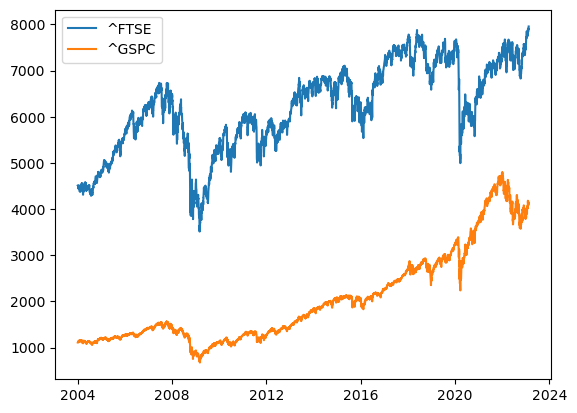

In [147]:
plt.plot(x.raw_data['Adj Close'])
plt.legend(['^FTSE', '^GSPC'])

In [148]:
x.log_returns['^GSPC']

Date
2004-01-02         NaN
2004-01-05    0.012319
2004-01-06    0.001291
2004-01-07    0.002364
2004-01-08    0.004951
                ...   
2023-02-08   -0.011143
2023-02-09   -0.008869
2023-02-10    0.002193
2023-02-13    0.011384
2023-02-14   -0.000280
Name: ^GSPC, Length: 4724, dtype: float64

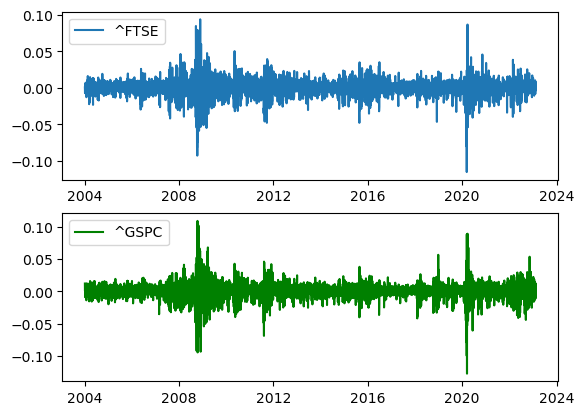

In [149]:
plt.figure()

plt.subplot(2, 1, 1)                            
plt.plot(x.log_returns['^FTSE'])
plt.legend(['^FTSE'])
plt.subplot(2, 1, 2)                               
plt.plot(x.log_returns['^GSPC'],color='g')  
plt.legend(['^GSPC'])
plt.show()

In [23]:
def compute_var(returns, alpha, window=None):
    """
    Input: pandas series of returns
    Output: percentile of return distribution at a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        if window==None:
            return np.percentile(returns, alpha)
        else:
            return returns.rolling(window).apply(lambda x: np.percentile(x,alpha), raw=True).dropna()
            # ALT: returns.rolling(window).quantile(alpha/100)
    else:
        raise TypeError("Expected a pandas data series")

def compute_es(returns, alpha, window=None):
    """
    Input: pandas series of returns
    Output: Expected shortfall for a given confidence interval alpha
    """
    if isinstance(returns, pd.Series):
        if window==None:
            belowVaR = returns <= compute_var(returns, alpha=alpha)
            return returns[belowVaR].mean()
        else:
            return returns.rolling(window).apply(lambda x: x[x<= compute_var(x, alpha)].mean()).dropna()
    else:
        raise TypeError("Expected a pandas data series")

In [24]:
var = compute_var(x.portfolio_return, 5, window=50)
es = compute_es(x.portfolio_return, 5, window=50)

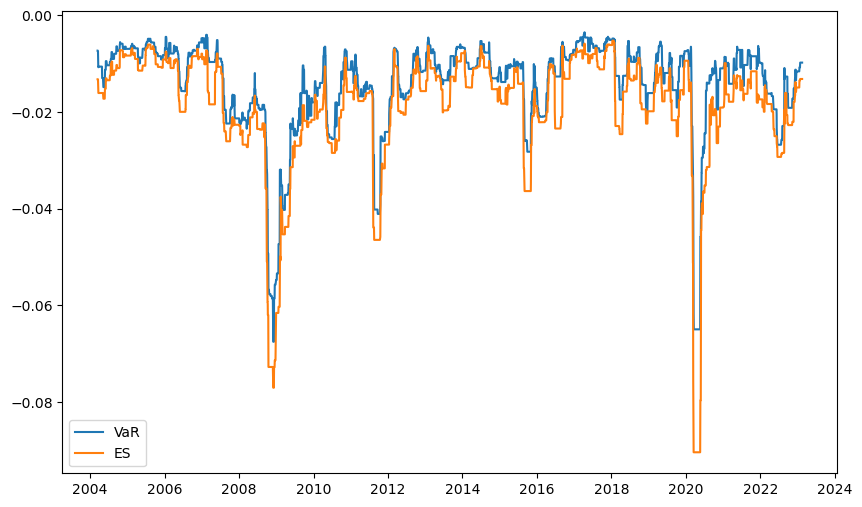

In [322]:
plt.figure(figsize=(10,6))
plt.plot(var, label='VaR')
plt.plot(es, label='ES')
plt.legend()
plt.show()

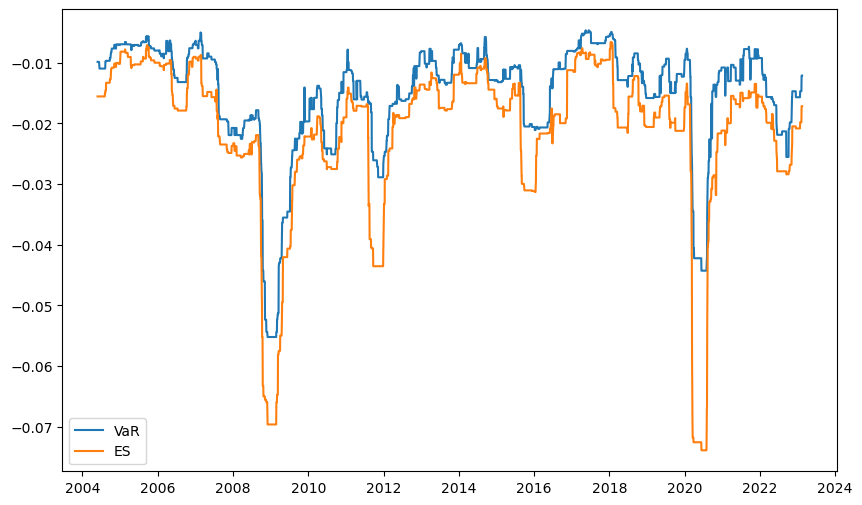

In [314]:
plt.figure(figsize=(10,6))
plt.plot(var, label='VaR')
plt.plot(es, label='ES')
plt.legend()
plt.show()

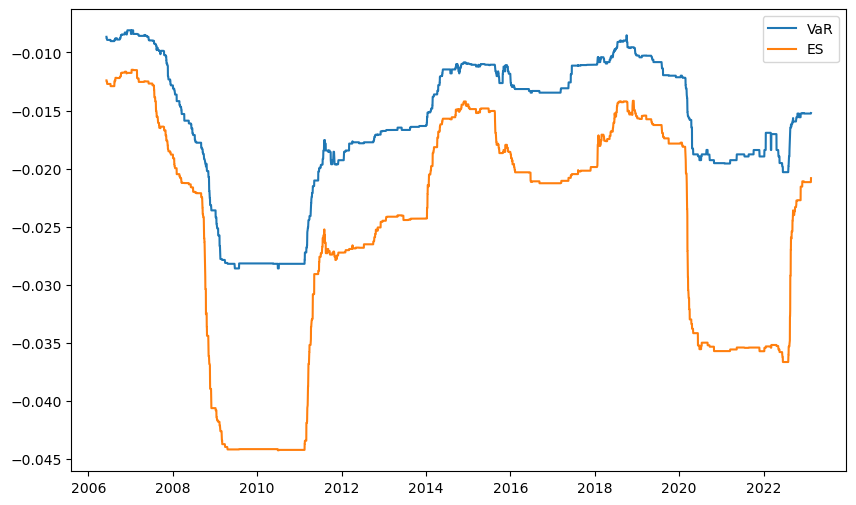

In [316]:
plt.figure(figsize=(10,6))
plt.plot(var, label='VaR')
plt.plot(es, label='ES')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date'>

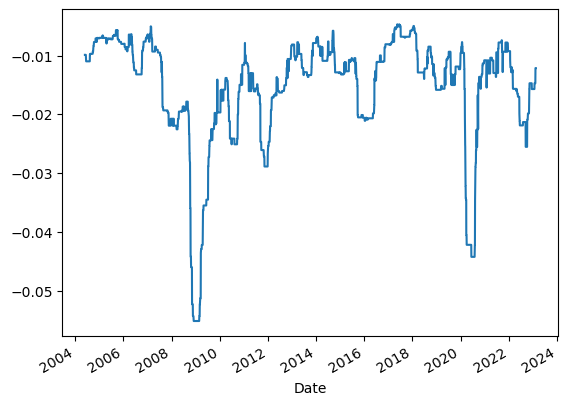

<AxesSubplot:xlabel='Date'>

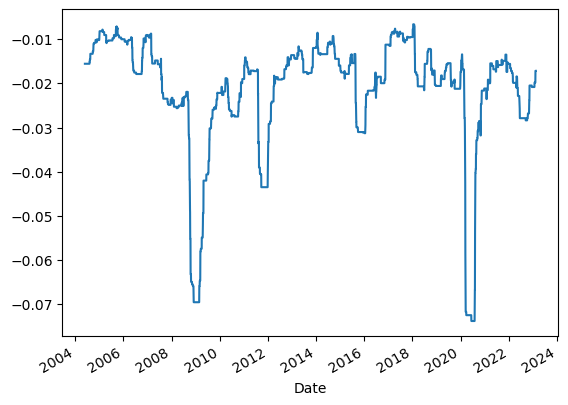

In [213]:
import time

In [200]:
# get the start time
st = time.time()

pp = x.portfolio_return.rolling(10).apply(lambda x: np.percentile(x, 5), raw=True)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds and', pp.mean())

Execution time: 0.28809547424316406 seconds and -0.011359162535289768


In [201]:
# get the start time
st = time.time()

pp = x.portfolio_return.rolling(10).apply(lambda x: np.percentile(x, 5), raw=False)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds and', pp.mean())

Execution time: 0.4959726333618164 seconds and -0.011359162535289768


In [2]:
from risk_management import value_at_risk as var
import timeit
import datetime as dt

x = var.Portfolio(var.tickers['crypto'], start=dt.datetime(2018,1,1), end=dt.datetime.today(), threshold=0.9)

In [4]:
x = var.Portfolio(var.tickers['crypto'], start=dt.datetime(2018,1,1), end=dt.datetime.today(), threshold=0.9)

[*********************100%***********************]  4 of 4 completed
{'YFI-GBP'}
1 columns were removed because there were less observations than the threshold (0.9):
YFI-GBP    942
dtype: int64
[*********************100%***********************]  1 of 1 completed
The data spans 1340 working days, but has 1873 observations.


In [5]:
x.raw_data

Adj Close                                  Close               \
                 BTC-GBP      ETH-GBP     MKR-GBP       BTC-GBP      ETH-GBP   
Date                                                                           
2018-01-01  10110.453125   571.987732  718.155945  10110.453125   571.987732   
2018-01-02  11021.922852   650.661377  782.071594  11021.922852   650.661377   
2018-01-03  11252.498047   712.650818  795.417908  11252.498047   712.650818   
2018-01-04  11512.325195   723.927673  767.712158  11512.325195   723.927673   
2018-01-05  12846.035156   735.347839  808.357910  12846.035156   735.347839   
...                  ...          ...         ...           ...          ...   
2023-02-12  18079.285156  1257.135620  568.154419  18079.285156  1257.135620   
2023-02-13  17948.546875  1240.430664  633.816589  17948.546875  1240.430664   
2023-02-14  18252.390625  1278.832764  608.464844  18252.390625  1278.832764   
2023-02-15  20194.128906  1390.491333  631.548950  20194.128906  1390.491333   
2023-02-17  20394.281250  1407.763062  602.844727  20394.281250  1407.763062   

                                High                                    Low  \
               MKR-GBP       BTC-GBP      ETH-GBP     MKR-GBP       BTC-GBP   
Date                                                                          
2018-01-01  718.155945  10460.455078   578.965698  729.147705   9750.722656   
2018-01-02  782.071594  11363.007812   677.150269  789.683411   9742.155273   
2018-01-03  795.417908  11458.170898   721.296082  807.341614  10931.148438   
2018-01-04  767.712158  11616.014648   771.333618  812.902527  10728.576172   
2018-01-05  808.357910  13049.233398   792.768188  823.786011  11211.503906   
...                ...           ...          ...         ...           ...   
2023-02-12  568.154419  18286.623047  1281.128418  600.387756  17971.681641   
2023-02-13  633.816589  18155.667969  1264.133545  643.565552  17683.435547   
2023-02-14  608.464844  18251.662109  1278.856201  636.991150  17834.091797   
2023-02-15  631.548950  20194.128906  1390.931274  631.817566  18175.708984   
2023-02-17  602.844727  20677.068359  1424.306641  615.347046  19595.220703   

                                             Open                           \
                ETH-GBP     MKR-GBP       BTC-GBP      ETH-GBP     MKR-GBP   
Date                                                                         
2018-01-01   549.999268  654.507446  10455.030273   559.902954  711.969177   
2018-01-02   571.726990  709.518311  10086.615234   571.769348  718.962097   
2018-01-03   639.507385  739.283813  11019.053711   651.806091  783.322327   
2018-01-04   698.888977  689.531128  11304.093750   711.905396  739.052490   
2018-01-05   704.942505  746.976440  11422.288086   720.110718  762.745422   
...                 ...         ...           ...          ...         ...   
2023-02-12  1244.477783  564.555603  18129.052734  1276.338745  599.702942   
2023-02-13  1212.389038  549.527588  18078.285156  1257.038818  568.207275   
2023-02-14  1232.860229  603.579468  17943.380859  1240.287720  633.683716   
2023-02-15  1272.213989  602.093872  18252.210938  1278.742432  608.431274   
2023-02-17  1366.588013  588.306030  19592.593750  1366.404663  588.227173   

                 Volume                        
                BTC-GBP     ETH-GBP   MKR-GBP  
Date                                           
2018-01-01   7618596387  1921646527    372254  
2018-01-02  12393585075  4254652954    486085  
2018-01-03  12489377571  3770197599    599189  
2018-01-04  16076162173  4799158506    540968  
2018-01-05  17571417359  4925670566   1221683  
...                 ...         ...       ...  
2023-02-12  14787440960  4414147731  21509312  
2023-02-13  19685651378  7706658764  75802478  
2023-02-14  22007706757  7597693438  47171902  
2023-02-15  26986031932  8320150697  39511953  
2023-02-17  34377011200  8154000896  33263820  

[1873 rows x 18 colum

In [4]:
x.tickers

{'GBPEUR=X', 'GBPJPY=X', 'GBPUSD=X'}

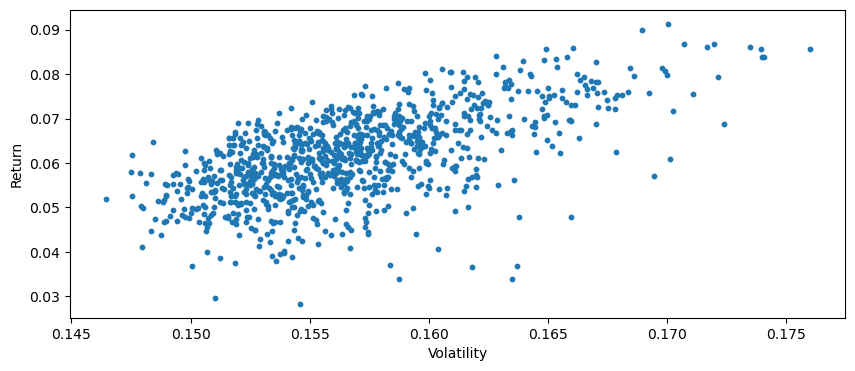

In [3]:
x.Efficient_Frontier()

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Text(0, 0.5, 'Return')

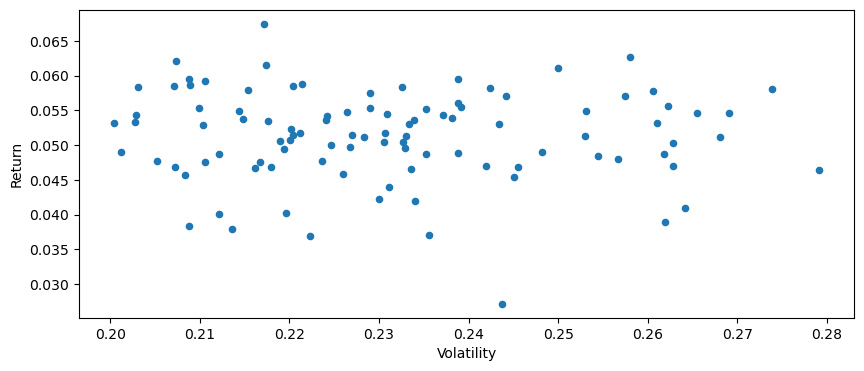

In [37]:
portfolio_returns = []
portfolio_volatilities = []
for i in range (100):
    weights = np.random.random(len(x.tickers))
    weights /= np.sum(weights)
    portfolio_returns.append(np.sum(weights * x.log_returns.mean())*250)
    portfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(x.log_returns.cov() * 250, weights))))
portfolios = pd.DataFrame({'Return': portfolio_returns, 'Volatility':portfolio_volatilities})
plt.figure(figsize=(10,4))
plt.scatter(x=portfolios['Volatility'],y=portfolios['Return'],s=20)
plt.xlabel("Volatility")
plt.ylabel("Return")

In [14]:
len(x.tickers)

101

In [29]:
x.equally_weighted()

In [34]:
var.compute_var(x.portfolio_return,1,window=25)

Date
2022-03-25   -0.020551
2022-03-28   -0.020551
2022-03-29   -0.020551
2022-03-30   -0.020551
2022-03-31   -0.020551
                ...   
2023-02-10   -0.009175
2023-02-13   -0.009175
2023-02-14   -0.009175
2023-02-15   -0.009175
2023-02-16   -0.009175
Length: 219, dtype: float64

In [15]:
x.portfolio_return

Date
2022-02-18    0.000000
2022-02-22   -0.006390
2022-02-23   -0.009025
2022-02-24   -0.012382
2022-02-25    0.030288
                ...   
2023-02-10   -0.000721
2023-02-13    0.009804
2023-02-14    0.000256
2023-02-15    0.004137
2023-02-16   -0.006024
Length: 243, dtype: float64

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 17 08:36:02 2023

@author: JHL
"""
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
import scipy.stats as stats

class Portfolio:
    def __init__(self, tickers=None, start=None, end=None, trading_days = 250):
        """
        Generate a portfolio from a list of tickers.
        .rawdata: {'Adj Close','Close','High','Low','Open','Volume'}
        -------------------
        tickers = []
        {start, end} = datetime
        trading_days = number of trading days in the year
        -------------------
        Defaults:
        Ticker: ^FTSE, Vodafone
        Start: 52 weeks from current date
        End: Current date
        -------------------
        Uses yahoo_finance
        -------------------
        example:
        x = Portfolio(tickers= ['LLOY.L','NWG.L','TSL3.L','TSCO.L','BOIL.AQ'], start=dt.datetime(2000,1,1), end=dt.datetime.today())
        """
# Setting default values to generate quick test instances
    # Use FTSE index if no ticker is provided
        if tickers==None:
            self.tickers = ['^FTSE','^GSPC']
            print ('No ticker provided, FTSE and S&P 500 was used')
        else: self.tickers = tickers
    # If no dates specified, use the range from 52 weeks ago till today
        if start==None:
            start = (dt.datetime.today()-dt.timedelta(weeks=52))
            print ('Default start date: {}'.format((dt.datetime.today()-dt.timedelta(weeks=52)).strftime('%d-%m-%y')))
        if end==None:
            end = (dt.datetime.today())
            print ('Default end date: {}'.format((dt.datetime.today()).strftime('%d-%m-%y')))
# Retieve the data from YahooFinance        
        self.raw_data = yf.download(self.tickers, start=start, end=end)
        self.risk_free_rate = yf.download('^TNX')['Adj Close']
# Quick indication of missing date
        print('The data spans {} working days, but has {} observations.'.format(np.busday_count(start.date(),end.date()),len(self.raw_data)))
        self.log_returns = np.log(self.raw_data['Adj Close'] / self.raw_data['Adj Close'].shift(1))
# Functions for creating portfolio returns and volatilities
    def Efficient_Frontier(self, n=1000, s=10):
        portfolio_returns = []
        portfolio_volatilities = []
        for x in range (n):
            weights = np.random.random(len(self.tickers))
            weights /= np.sum(weights)
            portfolio_returns.append(np.sum(weights * self.log_returns.mean())*250)
            portfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(self.log_returns.cov() * 250, weights))))
        self.portfolios = pd.DataFrame({'Return': portfolio_returns, 'Volatility':portfolio_volatilities})
        plt.figure(figsize=(10,4))
        plt.scatter(x=self.portfolios['Volatility'],y=self.portfolios['Return'],s=s)
        plt.xlabel("Volatility")
        plt.ylabel("Return")
    def equally_weighted(self):
        self.weights = np.ones(len(self.tickers))/len(self.tickers)
        self.portfolio_prices = portfolio_return(self.weights, self.raw_data['Adj Close'])
        self.portfolio_return = portfolio_return(self.weights, self.log_returns)
        self.portfolio_vol = portfolio_volatility(self.weights, self.log_returns)
    def randomly_weighted(self):
        self.weights = np.random.random(len(tickers))
        self.weights /= np.sum(self.weights)
        self.portfolio_prices = portfolio_return(self.weights, self.raw_data['Adj Close'])
        self.portfolio_return = portfolio_return(self.weights, self.log_returns)
        self.portfolio_vol = portfolio_volatility(self.weights, self.log_returns)
        
def portfolio_return(weights, log_returns, trading_days=None):
    if trading_days != None:
        return (np.sum(weights * log_returns.mean()) * trading_days)
    else: return (np.sum(weights * log_returns,axis=1))
def portfolio_volatility(weights, log_returns, trading_days=None):
    if trading_days != None:
        return (np.sqrt(np.dot(weights.T,np.dot(log_returns.cov() * trading_days, weights))))
    else: return (np.sqrt(np.dot(weights.T,np.dot(log_returns.cov(), weights))))
    
    

def compute_var(returns, alpha, window=None):
    """
    Input: pandas series of returns
    Output: percentile of return distribution at a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        if window==None:
            return np.percentile(returns, alpha)
        else:
            return returns.rolling(window).apply(lambda x: np.percentile(x,alpha), raw=True).dropna()
            # ALT: returns.rolling(window).quantile(alpha/100)
    else:
        raise TypeError("Expected a pandas data series")

def compute_es(returns, alpha, window=None):
    """
    Input: pandas series of returns
    Output: Expected shortfall for a given confidence interval alpha
    """
    if isinstance(returns, pd.Series):
        if window==None:
            belowVaR = returns <= compute_var(returns, alpha=alpha)
            return returns[belowVaR].mean()
        else:
            return returns.rolling(window).apply(lambda x: x[x<= compute_var(x, alpha)].mean()).dropna()
    else:
        raise TypeError("Expected a pandas data series")

In [8]:
x = Portfolio()

No ticker provided, FTSE and S&P 500 was used
Default start date: 18-02-22
Default end date: 17-02-23
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed
The data spans 260 working days, but has 258 observations.


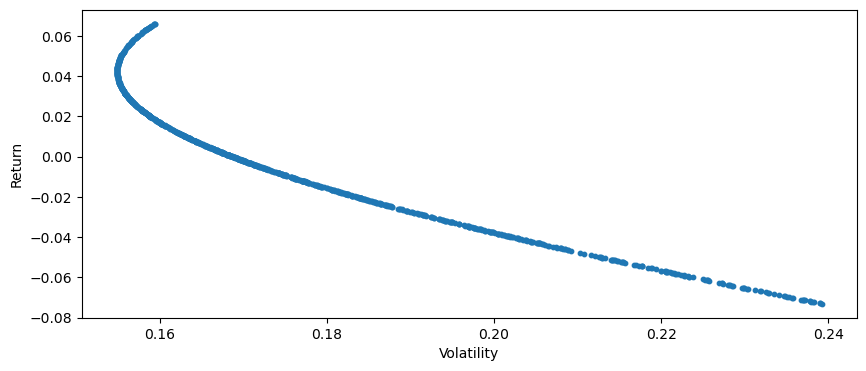

In [9]:
x.Efficient_Frontier()

In [22]:
funcs.column_na(x.raw_data)['Adj Close']

150 columns were removed because there were less observations than the threshold:
Adj Close  AAL       4379
           ABDN.L    4199
           AUTO         0
           BME       4506
           CCH.L     2480
                     ... 
Volume     PHNX.L    3348
           RMG.L        0
           RMV.L     4281
           SKG.L     4026
           SMIN      2775
Length: 150, dtype: int64


,ABF.L,ADM,AHT,ANTO.L,AON,AV.L,AVV.L,AZN,BA.L,BARC.L,...,STJ.L,SVT,TSCO,TW.L,ULVR.L,UTG,UU.L,VOD,WPP,WTB.L
Date,,,,,,,,,,,,,,,,,,,,,
2004-02-25,416.994202,11.099695,235.162918,132.276230,20.265020,197.083939,100.474213,11.606347,81.285126,258.801758,...,104.960396,2.557614,9.165786,107.432709,648.404724,5.275166,184.168228,11.085204,31.815454,560.946533
2004-02-26,414.882690,11.190886,237.547989,130.782761,20.148104,198.137878,100.474213,11.553813,83.601250,255.411972,...,103.514618,2.557614,9.191645,107.432709,647.600159,5.275166,184.168228,10.956802,32.127483,555.385437
2004-02-27,412.419495,11.203918,236.116974,130.356110,20.444283,198.137878,103.035667,11.611128,83.932137,252.282867,...,104.092934,2.557614,9.228283,109.662468,646.680664,5.272530,183.622879,10.687159,30.715166,547.970215
2004-03-01,411.363770,11.275570,243.033569,131.742844,20.592379,201.738815,103.234200,11.833224,86.248276,254.760025,...,104.382088,2.492864,9.327417,112.601677,650.933960,5.275166,186.713577,11.025279,29.943316,549.453064
2004-03-02,412.771393,11.223455,248.042053,133.876343,20.506641,203.495331,103.234200,11.649337,88.454094,255.281555,...,105.654305,2.468583,9.342503,115.540840,644.381165,5.272530,185.259262,10.785598,29.850256,559.092773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-12,1801.500000,86.914246,5.740000,1762.500000,315.312927,451.700012,3218.000000,70.080002,833.200012,177.080002,...,1243.000000,11.510000,220.740005,112.650002,4185.000000,29.986147,1045.500000,11.280000,55.910000,3020.000000
2023-01-13,1795.000000,87.918755,5.830000,1750.500000,316.610657,444.200012,3218.000000,71.080002,832.799988,180.740005,...,1242.500000,10.630000,221.089996,114.750000,4215.500000,30.085505,1037.000000,11.230000,56.689999,3033.000000
2023-01-17,1853.500000,87.610435,5.830000,1741.500000,316.381042,441.799988,3219.000000,70.739998,838.400024,180.940002,...,1251.000000,11.290000,218.990005,117.000000,4165.500000,30.145119,1039.500000,11.420000,56.770000,3028.000000


In [10]:
x = var.Portfolio(funcs.tickers['ftse100'], start=dt.datetime(2010,1,1), end=dt.datetime.today(), dropnan=False)

[*********************100%***********************]  101 of 101 completed

3 Failed downloads:
- MGGT.L: No timezone found, symbol may be delisted
- RMG.L: No timezone found, symbol may be delisted
- AUTO: No timezone found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
The data spans 3425 working days, but has 3378 observations.


In [14]:
def func(a=1, b=2, *kwargs):
    if c=="":
        print(a+b)
    else:
        print('no')

In [16]:
func()

NameError: name 'c' is not defined